<a href="https://colab.research.google.com/github/Taejin1221/Lab_Experiment/blob/main/Trajectory_Clustering/Trajectory_Clustering_16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import modules

In [1]:
import os, cv2, glob, time
import numpy as np
import pandas as pd

'''
If you want to know this file,
refer to https://github.com/smupilab/Trajectory-AE/blob/master/utils/convertImage.py
'''
import convertImage as utils
import matplotlib.pyplot as plt

# Set Constants

In [2]:
# Constants
WIDTH, HEIGHT = 128, 128

EXPERIMENT_DATA = {
    'name' : 'Trajectory_Clusetring(Vessel_Method)',
    'date' : '02-16-2022',
    'description' : 'Vessel method의 모델 훈련'
    }

ROOT_DIR = os.getcwd()
os.chdir(ROOT_DIR)

GEOLIFE_DIR = os.path.join('C:\\', 'Dataset', 'Geolife')
DATA_DIR = os.path.join(GEOLIFE_DIR, 'Data')
IMAGE_DIR = os.path.join(GEOLIFE_DIR, 'Image_Files')

if ( 'Results' not in os.listdir() ):
    os.mkdir( 'Results' )
RESULT_DIR = os.path.join( ROOT_DIR, 'Results')

plt.gray()

<Figure size 432x288 with 0 Axes>

# Load and Preprocessing Data

In [3]:
os.chdir(IMAGE_DIR)
file_names = sorted(glob.glob('*png'))

In [4]:
train_images = []
for file in file_names:
    src = cv2.imread(file, cv2.IMREAD_GRAYSCALE)
    dst = cv2.resize(src, dsize=(0, 0), fx=0.5, fy=0.5, interpolation=cv2.INTER_LINEAR)
    train_images.append(dst)

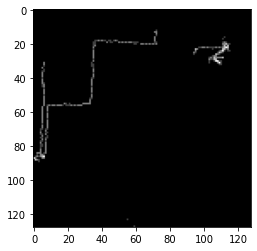

(128, 128)


In [5]:
plt.imshow(train_images[0])
plt.show()
print(train_images[0].shape)

In [6]:
X_train = np.array( train_images ).astype( 'float32' ) / 255.
X_train = np.reshape( X_train, ( -1, HEIGHT, WIDTH, 1 ) )

In [7]:
print( X_train.shape )

(18670, 128, 128, 1)


# Construct AE Model

In [8]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [9]:
af, pd = 'relu', 'same' # activation function and padding value

encode_input = layers.Input( ( HEIGHT, WIDTH, 1 ) )
x = layers.Conv2D( 32, ( 3, 3 ), activation = af, padding = pd )( encode_input )
x = layers.MaxPooling2D( ( 2, 2 ), padding = pd )( x )

x = layers.Conv2D( 32, ( 3, 3 ), activation = af, padding = pd )( x )
x = layers.MaxPooling2D( ( 2, 2 ), padding = pd )( x )

x = layers.Conv2D( 16, ( 3, 3 ), activation = af, padding = pd )( x )
x = layers.MaxPooling2D( ( 2, 2 ), padding = pd )( x )

x = layers.Conv2D( 16, ( 3, 3 ), activation = af, padding = pd )( x )
x = layers.MaxPooling2D( ( 2, 2 ), padding = pd )( x )

feature_map_shape = x.shape
flatten_size = feature_map_shape[1] * feature_map_shape[2] * feature_map_shape[3]

x = layers.Flatten()( x )
encode_output = layers.Dense( flatten_size , activation = af )( x )

In [10]:
encoder = keras.Model( encode_input, encode_output, name = 'Encoder' )
encoder.summary()

Model: "Encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 128, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 128, 128, 32)      320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 16)        4624      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 16, 16)        0   

In [11]:
decode_input = layers.Input( ( flatten_size ) )

x = layers.Dense( flatten_size, activation = af )( decode_input )
x = layers.Reshape( feature_map_shape[1:] )( x )

x = layers.Conv2DTranspose( 16, ( 3, 3 ), activation = af, padding = pd )( x )
x = layers.UpSampling2D( ( 2, 2 ) )( x )

x = layers.Conv2DTranspose( 16, ( 3, 3 ), activation = af, padding = pd )( x )
x = layers.UpSampling2D( ( 2, 2 ) )( x )

x = layers.Conv2DTranspose( 32, ( 3, 3 ), activation = af, padding = pd )( x )
x = layers.UpSampling2D( ( 2, 2 ) )( x )

x = layers.Conv2DTranspose( 32, ( 3, 3 ), activation = af, padding = pd )( x )
x = layers.UpSampling2D( ( 2, 2 ) )( x )

decode_output = layers.Conv2DTranspose( 1, ( 3, 3 ), activation = af, padding = pd )( x )

In [12]:
decoder = keras.Model( decode_input, decode_output, name = 'Decoder' )
decoder.summary()

Model: "Decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 1024)]            0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              1049600   
_________________________________________________________________
reshape (Reshape)            (None, 8, 8, 16)          0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 8, 8, 16)          2320      
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 16, 16, 16)        0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 16, 16, 16)        2320      
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 32, 32, 16)        0   

In [13]:
auto_encoder = keras.Model( encode_input, decoder( encoder( encode_input ) ), name = 'Auto_Encoder' )
auto_encoder.summary()

Model: "Auto_Encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 128, 1)]     0         
_________________________________________________________________
Encoder (Functional)         (None, 1024)              1066112   
_________________________________________________________________
Decoder (Functional)         (None, 128, 128, 1)       1068417   
Total params: 2,134,529
Trainable params: 2,134,529
Non-trainable params: 0
_________________________________________________________________


# Traing Model

In [14]:
auto_encoder.compile( 'adam', loss = 'mse' )

In [15]:
EPOCH = 300
BATCH = 256

In [16]:
history = auto_encoder.fit( X_train, X_train, epochs = EPOCH, batch_size = BATCH  )

Epoch 1/300
73/73 [==============================] - 20s 166ms/step - loss: 0.0027
Epoch 2/300
73/73 [==============================] - 11s 148ms/step - loss: 0.0025
Epoch 3/300
73/73 [==============================] - 11s 148ms/step - loss: 0.0024
Epoch 4/300
73/73 [==============================] - 11s 148ms/step - loss: 0.0023
Epoch 5/300
73/73 [==============================] - 11s 148ms/step - loss: 0.0022
Epoch 6/300
73/73 [==============================] - 11s 149ms/step - loss: 0.0021
Epoch 7/300
73/73 [==============================] - 11s 149ms/step - loss: 0.0021
Epoch 8/300
73/73 [==============================] - 11s 149ms/step - loss: 0.0020
Epoch 9/300
73/73 [==============================] - 11s 150ms/step - loss: 0.0020
Epoch 10/300
73/73 [==============================] - 11s 150ms/step - loss: 0.0020
Epoch 11/300
73/73 [==============================] - 11s 150ms/step - loss: 0.0019
Epoch 12/300
73/73 [==============================] - 11s 150ms/step - loss: 0.0019
E

# Test Model

In [18]:
os.chdir( RESULT_DIR )

new_result_dir = f"{EXPERIMENT_DATA['name']}_{EXPERIMENT_DATA['date']}_Data"
os.mkdir( new_result_dir )
os.chdir( new_result_dir )

encoder.save('encoder.h5')
decoder.save('decoder.h5')
auto_encoder.save('auto_encoder.h5')

with open( 'Description.txt', 'w' ) as f:
    f.write( EXPERIMENT_DATA['description'] )

## Check Reconstruction

Trajectory_Clusetring(Vessel_Method)_Reconstruction(02-16-2022).png


<Figure size 432x288 with 0 Axes>

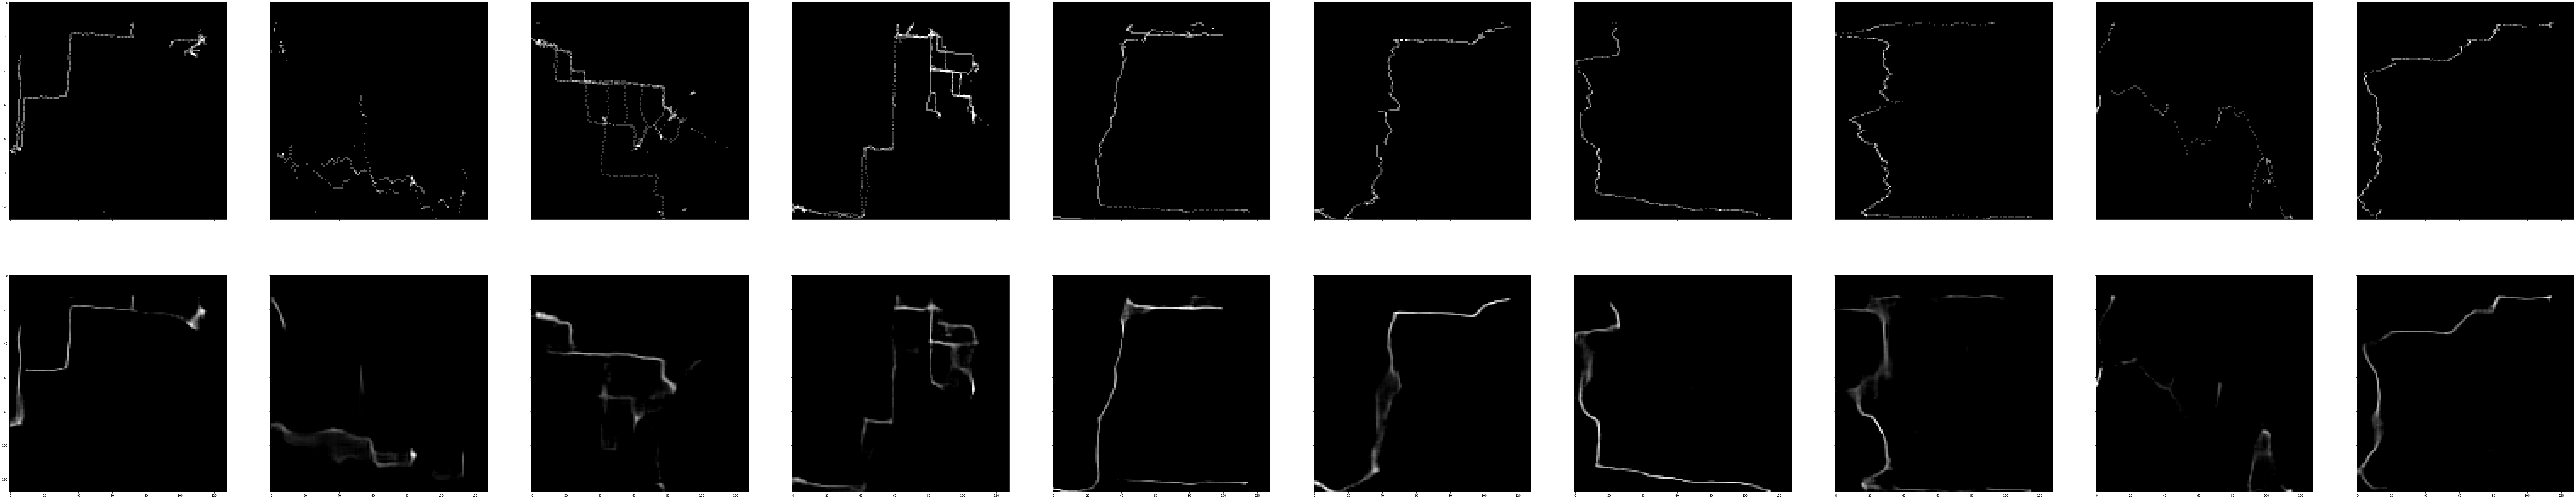

In [22]:
n = 10
decoded_img = auto_encoder(X_train[:n])

plt.gray()

fig, ax = plt.subplots( 2, n, sharex = True, sharey = True, figsize = ( 160, 32 ) )
for i in range( n ):
    ax[0][i].imshow( X_train[i].reshape( HEIGHT, WIDTH ) )
    ax[1][i].imshow( tf.reshape( decoded_img[i], ( HEIGHT, WIDTH ) ) )

result_name = (EXPERIMENT_DATA['name'] + '_'
    + 'Reconstruction' + '('
    + EXPERIMENT_DATA['date'] + ').png')
print( result_name )

plt.savefig( result_name, dpi = 100 )
plt.show()